In [1]:
import numpy as np
from myplotstyle import plt, get_figsize

from easyquery import Query, QueryMaker
import SAGA
from SAGA import ObjectCuts as C
from SAGA import HostCuts as H

from astropy.table import unique
from fast_histogram import histogram2d
import cmcrameri.cm as cmc

In [2]:
print(SAGA.__version__)
saga = SAGA.QuickStart()

3.0.0
SAGA `shared_dir` set to /home/yymao/Dropbox/Work/SAGA
SAGA `local_dir`  set to /home/yymao/Documents/Work/Data/SAGA


In [3]:
base = H.paper3.filter(saga.object_catalog.load_combined_base_catalog())
nhosts = len(np.unique(base["HOSTID"]))
assert nhosts == 101

In [4]:
specs_full = Query(C.is_clean2, C.is_galaxy2, C.sat_rcut, C.has_spec, "RHOST_KPC > 10", "SPEC_Z >= 0.002", "SPEC_Z < 0.8").filter(base, ["OBJID", "r_mag", "SPEC_Z", "SPEC_REPEAT", "sb_r"])
specs_full = unique(specs_full, "OBJID")
specs_saga = C.has_our_specs_only.filter(specs_full)

In [5]:
full_sq_deg = 84.70  # from F01-host footprint

r_range = (14, 21)
z_range = (0, 0.8)
r_bins = 21
z_bins = 28

r_edges = np.linspace(*r_range, num=(r_bins+1))
r_center = 0.5 * (r_edges[1:] + r_edges[:-1])
z_edges = np.linspace(*z_range, num=(z_bins+1))
z_center = 0.5 * (z_edges[1:] + z_edges[:-1])

r_mesh, z_mesh = np.meshgrid(r_center, z_center, indexing="ij")
r_mesh = r_mesh.ravel()
z_mesh = z_mesh.ravel()

n_all = histogram2d(specs_full["r_mag"], specs_full["SPEC_Z"], bins=(r_bins, z_bins), range=[r_range, z_range])
n_saga = histogram2d(specs_saga["r_mag"], specs_saga["SPEC_Z"], bins=(r_bins, z_bins), range=[r_range, z_range])

count = n_all.ravel()
frac = np.where(count > 0, n_saga.ravel() / count, 0.5)

/tmp/ipykernel_11500/520775440.py:21: RuntimeWarning: invalid value encountered in divide
  frac = np.where(count > 0, n_saga.ravel() / count, 0.5)


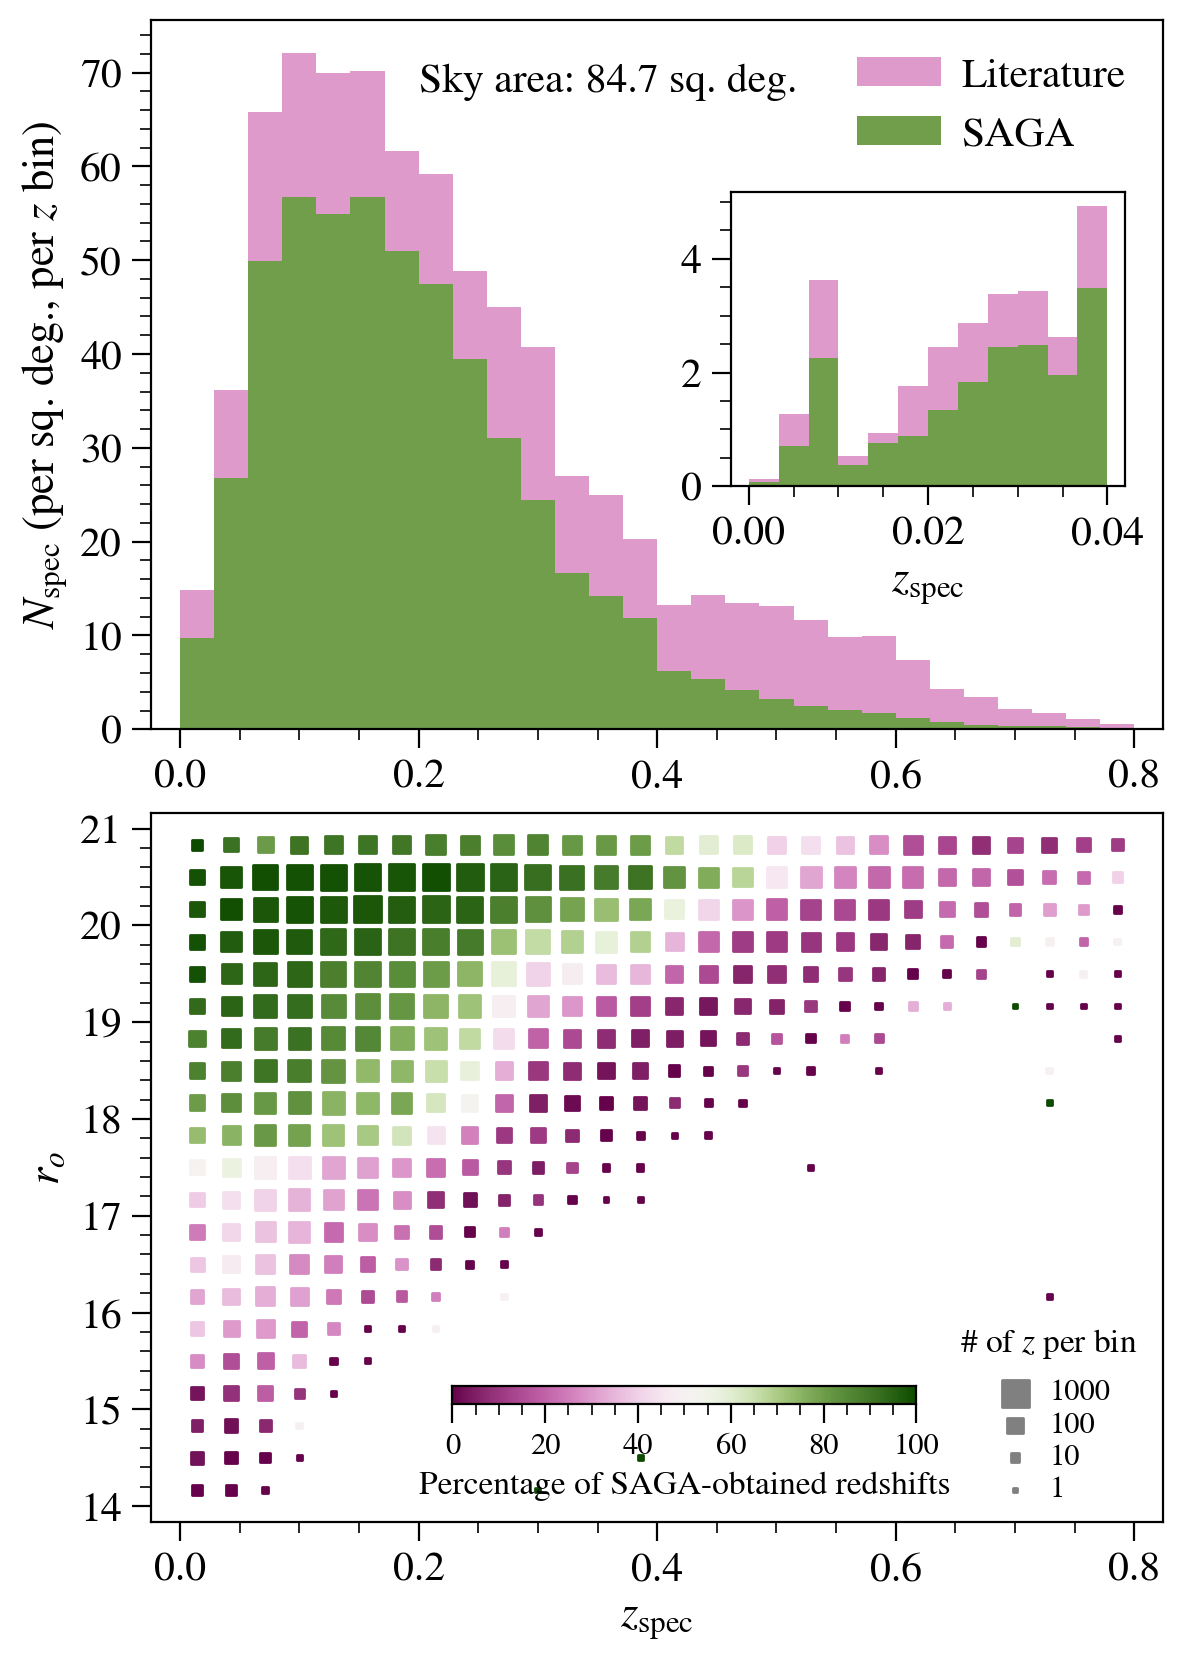

In [6]:
fig, ax = plt.subplots(nrows=2, figsize=get_figsize(ratio=0.7))

ax[0].bar(z_edges[:-1], n_all.sum(axis=0) / full_sq_deg, width=np.ediff1d(z_edges), align="edge", color=cmc.bam(0.3), label='Literature')
ax[0].bar(z_edges[:-1], n_saga.sum(axis=0) / full_sq_deg, width=np.ediff1d(z_edges), align="edge", color=cmc.bam(0.8), label='SAGA')
ax[0].legend(loc='upper right')
ax[0].text(0.2, 68, f"Sky area: {full_sq_deg:.1f} sq. deg.", ha="left")

z_edges_zoom = np.linspace(0, 0.04, 13)
ax_inset = fig.add_axes([0.62, 0.71, 0.34, 0.18])
ax_inset.hist(specs_full["SPEC_Z"], z_edges_zoom, weights=np.ones(len(specs_full))/full_sq_deg, color=cmc.bam(0.3))
ax_inset.hist(specs_saga["SPEC_Z"], z_edges_zoom, weights=np.ones(len(specs_saga))/full_sq_deg, color=cmc.bam(0.8))
ax_inset.set_xlabel(r'$z_{\rm spec}$')

ax[1].scatter(z_mesh, r_mesh, c=frac, s=np.sqrt(count)*3, cmap=cmc.bam, vmax=1, vmin=0, marker="s")

ax_colorbar = fig.add_axes([0.38, 0.15, 0.4, 0.011])
ax_colorbar.imshow(np.atleast_2d(np.linspace(0, 1, 512)), aspect='auto', extent=(0, 100, 0, 1), cmap=cmc.bam, label="colorbar")
ax_colorbar.yaxis.set_visible(False)
ax_colorbar.tick_params(labelsize=11)
ax_colorbar.set_xlabel(r"Percentage of SAGA-obtained redshifts", fontsize=12)

ax[1].scatter([z_center[-4]] * 4, r_center[:4], s=np.sqrt([1, 10, 100, 1000])*3, c="grey", marker="s")
for y, n in zip(r_center[:4], [1, 10, 100, 1000]):
    ax[1].text(z_center[-3], y, f"{n}", fontsize=11, va="center")
ax[1].text(z_center[-3], r_center[4], f"# of $z$ per bin", fontsize=12, va="bottom", ha="center")

ax[1].set_xlabel(r'$z_{\rm spec}$')
ax[1].set_ylabel(r'$r_o$')

ax[0].set_xlim(ax[1].get_xlim())
ax[0].set_ylabel(r'$N_{\rm spec}$ (per sq. deg., per $z$ bin)')

plt.savefig("plots/z_distribution.pdf")

In [7]:
full_sq_deg = 84.70  # from F01-host footprint

r_range = (14, 21)
r_bins = 28
sb_range = (16.5, 27.5)
sb_bins = 21

r_edges = np.linspace(*r_range, num=(r_bins+1))
r_center = 0.5 * (r_edges[1:] + r_edges[:-1])
sb_edges = np.linspace(*sb_range, num=(sb_bins+1))
sb_center = 0.5 * (sb_edges[1:] + sb_edges[:-1])

sb_mesh, r_mesh = np.meshgrid(sb_center, r_center, indexing="ij")
r_mesh = r_mesh.ravel()
sb_mesh = sb_mesh.ravel()

n_all = histogram2d(specs_full["sb_r"], specs_full["r_mag"], bins=(sb_bins, r_bins), range=[sb_range, r_range])
n_saga = histogram2d(specs_saga["sb_r"], specs_saga["r_mag"], bins=(sb_bins, r_bins), range=[sb_range, r_range])

count = n_all.ravel()
frac = np.where(count > 0, n_saga.ravel() / count, 0.5)

/tmp/ipykernel_11500/3888492445.py:21: RuntimeWarning: invalid value encountered in divide
  frac = np.where(count > 0, n_saga.ravel() / count, 0.5)


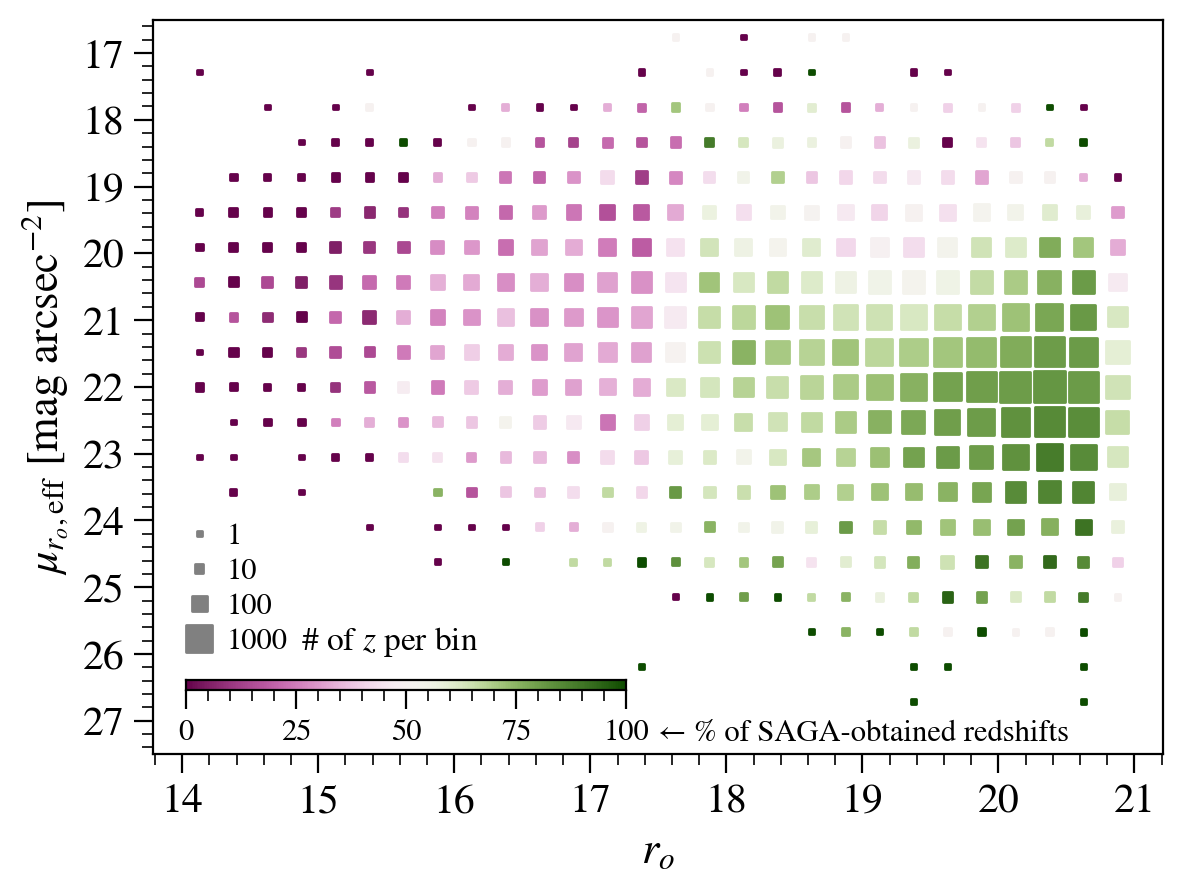

In [8]:
fig, ax = plt.subplots()
ax.scatter(r_mesh, sb_mesh, c=frac, s=np.sqrt(count)*2.8, cmap=cmc.bam, vmax=1, vmin=0, marker="s")
ax.set_ylim(sb_range[::-1])
ax_colorbar = fig.add_axes([0.15, 0.22, 0.38, 0.011])
ax_colorbar.imshow(np.atleast_2d(np.linspace(0, 1, 512)), aspect='auto', extent=(0, 100, 0, 1), cmap=cmc.bam, label="colorbar")
ax_colorbar.yaxis.set_visible(False)
ax_colorbar.tick_params(labelsize=11)
ax.text(17.5, 27.3, "← % of SAGA-obtained redshifts", fontsize=11)


ax.scatter([r_center[0]] * 4, sb_center[-7:-3]+0.1, s=np.sqrt([1, 10, 100, 1000])*2.8, c="grey", marker="s")
for y, n in zip(sb_center[-7:-3], [1, 10, 100, 1000]):
    ax.text(r_center[1]-0.05, y+0.15, f"{n}", fontsize=11, va="center")
ax.text(r_center[3], sb_center[-4]+0.15, f"# of $z$ per bin", fontsize=12, va="center")

ax.set_xticks(np.arange(14, 21.5))
ax.set_yticks(np.arange(17, 27.5))

ax.set_xlabel(r'$r_o$')
ax.set_ylabel("$\\mu_{r_o, \\mathrm{eff}}$ [mag arcsec$^{-2}$]")


plt.savefig("plots/z_distribution_sb-mag.pdf")